In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns  # This optional package makes plots prettier

import openmc

## The statepoint file

Let's begin by loading the statepoint HDF5 file for batch 50 into the Python API's `openmc.StatePoint` class:

In [2]:
!cp ../Part2/statepoint.50.h5 ../Part2/summary.h5 .

In [3]:
sp = openmc.StatePoint('statepoint.50.h5')

The statepoint file contains some metadata like the date and time that it was written.

In [4]:
sp.date_and_time

datetime.datetime(2022, 6, 13, 9, 39, 19)

OpenMC computes a number of estimators for the multiplication factor $k_\text{eff}$. Each of these estimators is stored as an attribute in the `StatePoint` class. We can report an ensemble-averaged estimator through the `StatePoint.k_combined` property with an `ndarray` storing the mean and uncertainty.

In [5]:
sp.k_combined

1.321048054381692+/-0.0036189655426031044

## Convergence of k and entropy

The statepoint file records the $k_\text{eff}$ and entropy values for every neutron generation.  These values should be converged in the inactive batches.  Let's plot them with Matplotlib.

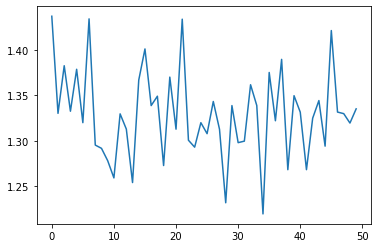

In [6]:
plt.plot(sp.k_generation)

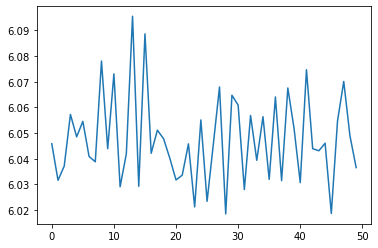

In [7]:
plt.plot(sp.entropy)

It looks like entropy still had some long-term trends in the active batches between about 10 and 40.  That means are tallies probably have some bias in them.  A proper calculation should use more inactive batches (or a better initial guess on the source distribution), but this is good enough for demonstration purposes.

## Getting Tally objects from the statepoint

Our `StatePoint` also has a number of different `Tally` objects stored in the `StatePoint.tallies` as a `dict`. We can inspect one the `Tally` objects by directly indexing into `tallies` with the appropriate ID:

In [8]:
sp.tallies.keys()

dict_keys([1, 3, 2])

In [9]:
sp.tallies[1]

Tally
	ID             =	1
	Name           =	mesh fission
	Filters        =	MeshFilter
	Nuclides       =	total U235
	Scores         =	['total', 'fission']
	Estimator      =	tracklength

Sometimes you may not know the ID number of the tally.  So in order to find the tally you need, there is a `get_tally(...)` method which allows one to retrieve a `Tally` object with an arbitrary subset or combination of the following information:

* integer ID
* string name
* one or more string scores
* one or more `Filter` objects
* one or more string nuclides

As an example, let's retrieve the `Tally` using its string name:

In [10]:
mesh_fiss = sp.get_tally(name='mesh fission')

As we can see, this has extracted the `Tally` with the name `"mesh_fiss"` into a new Python variable called `mesh_fiss`. Let's extract a few other `Tally` objects into their own respective variables.

In [11]:
distribcell = sp.get_tally(name='distribcell')
# There are many ways to locate tallies, including scores.
flux = sp.get_tally(scores=['flux'])

## Pandas DataFames for tallies

The easiest way to analyze tallies in the Python API is with the [Pandas](http://pandas.pydata.org/) Python package.

In [12]:
df = mesh_fiss.get_pandas_dataframe()
df.head(10)  # Show the first 10 rows

mesh 1       nuclide    score      mean std. dev.
       x  y  z                                     
0      1  1  1   total    total  0.142031  0.003817
1      1  1  1   total  fission  0.000000  0.000000
2      1  1  1    U235    total  0.000000  0.000000
3      1  1  1    U235  fission  0.000000  0.000000
4      2  1  1   total    total  0.216346  0.003628
5      2  1  1   total  fission  0.004250  0.000173
6      2  1  1    U235    total  0.005511  0.000210
7      2  1  1    U235  fission  0.004058  0.000172
8      3  1  1   total    total  0.214619  0.003039
9      3  1  1   total  fission  0.004210  0.000170

In [13]:
df = flux.get_pandas_dataframe()
df.head(10)

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.010000,0.010864,total,flux,0.032953,0.001020
1,0.010864,0.011803,total,flux,0.038418,0.001053
2,0.011803,0.012823,total,flux,0.045669,0.001536
3,0.012823,0.013932,total,flux,0.052456,0.001422
4,0.013932,0.015136,total,flux,0.057391,0.001284
5,0.015136,0.016444,total,flux,0.067802,0.001466
6,0.016444,0.017865,total,flux,0.075720,0.001844
7,0.017865,0.019409,total,flux,0.086954,0.001529
8,0.019409,0.021086,total,flux,0.096428,0.001794
9,0.021086,0.022909,total,flux,0.111349,0.002107


In [14]:
df = distribcell.get_pandas_dataframe()
df.head(10)

level 1      level 2       level 3      distribcell nuclide    score  \
     univ cell     lat          univ cell                                
       id   id      id  x  y      id   id                                
0      11   22      10  1  0       1    1           0   total    total   
1      11   22      10  1  0       1    1           0   total  fission   
2      11   22      10  1  0       1    1           0    U235    total   
3      11   22      10  1  0       1    1           0    U235  fission   
4      11   22      10  2  0       1    1           1   total    total   
5      11   22      10  2  0       1    1           1   total  fission   
6      11   22      10  2  0       1    1           1    U235    total   
7      11   22      10  2  0       1    1           1    U235  fission   
8      11   22      10  4  0       1    1           2   total    total   
9      11   22      10  4  0       1    1           2   total  fission   

       mean std. dev.  
                       
                       
0  0.042011  0.000879  
1  0.004250  0.000173  
2  0.005511  0.000210  
3  0.004058  0.000172  
4  0.043347  0.000847  
5  0.004210  0.000170  
6  0.005474  0.000211  
7  0.004014  0.000169  
8  0.043623  0.000845  
9  0.004452  0.000191

Pandas does more than just format tables.  Pandas is a very powerful data processing tool.  One of the most important features is "fancy indexing".  This allows you to quickly isolate the data you want using a Boolean expression.  For example, here's how to focus on reaction rates for U-235.

In [15]:
df = mesh_fiss.get_pandas_dataframe()
indices = df['nuclide'] == 'U235'
indices.head(5)

0    False
1    False
2     True
3     True
4    False
Name: nuclide, dtype: bool

In [16]:
sub_df = df[df['nuclide'] == 'U235']
sub_df.head(5)

mesh 1       nuclide    score      mean std. dev.
        x  y  z                                     
2       1  1  1    U235    total  0.000000  0.000000
3       1  1  1    U235  fission  0.000000  0.000000
6       2  1  1    U235    total  0.005511  0.000210
7       2  1  1    U235  fission  0.004058  0.000172
10      3  1  1    U235    total  0.005474  0.000211

Now consider the case where we wish to select from `sub_df` those mesh cells which have a "fission" rate that is above the average:

In [17]:
# Replace 0's with NaN to eliminate them from average.
sub_df = sub_df.replace(0, np.nan)

# Extract rows corresponding to above-average fission rates.
indices = sub_df['mean'] > sub_df['mean'].mean()
above_avg = sub_df[indices]
above_avg.head(5)

mesh 1       nuclide  score      mean std. dev.
        x  y  z                                   
42      2  2  1    U235  total  0.011037  0.000283
46      3  2  1    U235  total  0.011046  0.000395
50      4  2  1    U235  total  0.011343  0.000366
54      5  2  1    U235  total  0.010791  0.000343
58      6  2  1    U235  total  0.010717  0.000321

Finally, let's use Pandas fancy indexing to select the data corresponding to those mesh cells in the lower left triangle of the mesh:

In [18]:
indices = df[('mesh 1', 'x')] > df[('mesh 1', 'y')]
lower = df[indices]
lower.head(5)

mesh 1       nuclide    score      mean std. dev.
       x  y  z                                     
4      2  1  1   total    total  0.216346  0.003628
5      2  1  1   total  fission  0.004250  0.000173
6      2  1  1    U235    total  0.005511  0.000210
7      2  1  1    U235  fission  0.004058  0.000172
8      3  1  1   total    total  0.214619  0.003039

## Plotting flux tallies

Next, let's use Matplotlib to plot the flux energy spectrum.  The first step is to get the DataFrame for the flux tally and extract the mean values.

In [19]:
df = flux.get_pandas_dataframe()
df.head(5)

,energy low [eV],energy high [eV],nuclide,score,mean,std. dev.
0,0.010000,0.010864,total,flux,0.032953,0.001020
1,0.010864,0.011803,total,flux,0.038418,0.001053
2,0.011803,0.012823,total,flux,0.045669,0.001536
3,0.012823,0.013932,total,flux,0.052456,0.001422
4,0.013932,0.015136,total,flux,0.057391,0.001284


In [20]:
# Extract the flux mean values array
fluxes = df['mean'].values

We also need an array of the energy grid points.  We could get that array from the `'energy low [eV]'` and the `'energy high [eV]'` columns of the DataFrame, but it is easier to extract from the `EnergyFilter` attached to the tally.

In [21]:
# Extract the energy bins from the Tally's EnergyFilter
energy_filter = flux.find_filter(openmc.EnergyFilter)
energies = energy_filter.bins

Text(0, 0.5, 'Flux')

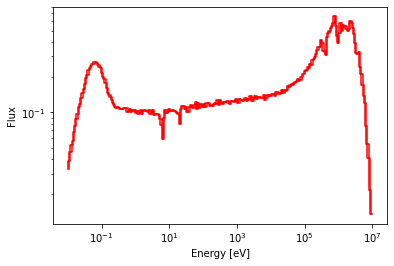

In [22]:
fig = plt.figure()
plt.loglog(energies, fluxes, drawstyle='steps', c='r')
plt.xlabel('Energy [eV]')
plt.ylabel('Flux')

## Potting mesh tallies

Mesh tallies can be quickly plotted with the `matplotlib.imshow` function.

In [23]:
df = mesh_fiss.get_pandas_dataframe()
df.head(5)

mesh 1       nuclide    score      mean std. dev.
       x  y  z                                     
0      1  1  1   total    total  0.142031  0.003817
1      1  1  1   total  fission  0.000000  0.000000
2      1  1  1    U235    total  0.000000  0.000000
3      1  1  1    U235  fission  0.000000  0.000000
4      2  1  1   total    total  0.216346  0.003628

In [24]:
ufiss = df[(df['nuclide'] == 'U235') & (df['score'] == 'fission')]
mean = ufiss['mean'].values
rel_err = ufiss['std. dev.'].values / mean

# Reshape the arrays.
mean.shape = (9, 9) #(17, 17)
rel_err.shape = (9, 9) #(17, 17)

# The edges are half-width; account for that.
mean[0, :] *= 2
mean[:, 0] *= 2

# Transpose them to match the order expected by imshow.
mean = mean.T
rel_err = rel_err.T

/var/tmp/pbs.683536.lemhipbs/ipykernel_1329009/2653982795.py:3: RuntimeWarning: invalid value encountered in true_divide
  rel_err = ufiss['std. dev.'].values / mean


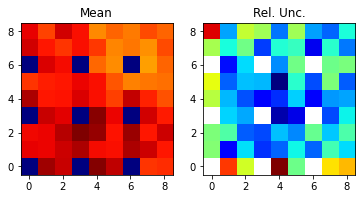

In [25]:
# Plot the mean on the left.
fig = plt.subplot(121)
plt.imshow(mean, interpolation='none', cmap='jet')
plt.ylim(plt.ylim()[::-1])  # Invert the y-axis.
plt.title('Mean')
plt.grid(False)

# Plot the uncertainty on the right.
fig2 = plt.subplot(122)
plt.imshow(rel_err, interpolation='none', cmap='jet')
plt.ylim(plt.ylim()[::-1])  # Invert the y-axis.
plt.title('Rel. Unc.')
plt.grid(False)

This mesh tally of fission rates particularly informative since the dark blue guide tube do not have any fission and skew the color bar. We can rectify this issue with a little trick to Matplotlib's color scheme as follows.

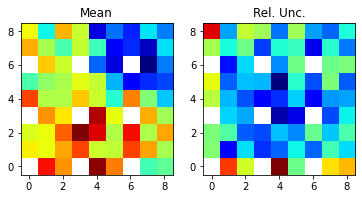

In [26]:
# Assign a NaN to zero fission rates in guide tubes
# Matplotlib will ignore "bad" values in the colorbar
mean[mean == 0.] = np.nan
cmap = plt.get_cmap('jet').copy()
cmap.set_bad(alpha=0.)

# Plot the mean on the left.
fig = plt.subplot(121)
plt.imshow(mean, interpolation='none', cmap='jet')
plt.ylim(plt.ylim()[::-1])  # Invert the y-axis.
plt.title('Mean')
plt.grid(False)

# Plot the uncertainty on the right.
fig2 = plt.subplot(122)
plt.imshow(rel_err, interpolation='none', cmap='jet')
plt.ylim(plt.ylim()[::-1])  # Invert the y-axis.
plt.title('Rel. Unc.')
plt.grid(False)

## Other ways to get tally data

Note that Pandas DataFrames are not the only way to interact with tally data!  If DataFrames do not work with your use case, try the `Tally.get_value()` method or accessing `Tally.mean` and `Tally.std_dev` directly.